In [15]:
import torch_rbf as rbf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic

# Defining an RBF network class

class MyDataset(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return (x, y)

class Network(nn.Module):
    
    def __init__(self, layer_widths, layer_centres, basis_func):
        super(Network, self).__init__()
        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        for i in range(len(layer_widths) - 1):
            self.rbf_layers.append(rbf.RBF(layer_widths[i], layer_centres[i], basis_func))
            self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i+1]))
    
    def forward(self, x):
        out = x
        for i in range(len(self.rbf_layers)):
            out = self.rbf_layers[i](out)
            out = self.linear_layers[i](out)
        return out
    
    def fit(self, x, y, epochs, batch_size, lr, loss_func):
        self.train()
        obs = x.size(0)
        trainset = MyDataset(x, y)
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
        optimiser = torch.optim.Adam(self.parameters(), lr=lr)
        epoch = 0
        while epoch < epochs:
            epoch += 1
            current_loss = 0
            batches = 0
            progress = 0
            for x_batch, y_batch in trainloader:
                batches += 1
                optimiser.zero_grad()
                y_hat = self.forward(x_batch)
                loss = loss_func(y_hat, y_batch)
                current_loss += (1/batches) * (loss.item() - current_loss)
                loss.backward()
                optimiser.step()
                progress += y_batch.size(0)
                sys.stdout.write('\rEpoch: %d, Progress: %d/%d, Loss: %f      ' % \
                                 (epoch, progress, obs, current_loss))
                sys.stdout.flush()


In [11]:
folder_path = os.path.expanduser('~/scratch/nanophoto/')
imagenp = np.load(folder_path + '1image.npy')
imagenp = (imagenp - imagenp.min())/(imagenp.max()-imagenp.min())
imagenp = np.round(imagenp)

In [57]:
# make grid
stepsx = 101
stepsy = 91
x_span = np.linspace(-1, 1, stepsx)
y_span = np.linspace(-1, 1, stepsy)
xx, yy = np.meshgrid(x_span, y_span)
values = np.append(xx.ravel().reshape(xx.ravel().shape[0], 1),
                   yy.ravel().reshape(yy.ravel().shape[0], 1),
                   axis=1)

# samples
samples = 512
x_obs_idx = np.random.randint(0,101, samples)
y_obs_idx = np.random.randint(0,91, samples)

pts_obs = np.stack((x_span[x_obs_idx], y_span[y_obs_idx]), axis=1)
z_obs = imagenp[x_obs_idx, y_obs_idx]

tx = torch.tensor(pts_obs, dtype=torch.float)
ty = torch.tensor(z_obs, dtype=torch.float).unsqueeze(1)

layer_widths = [2, 1]
layer_centres = [40]
basis_func = rbf.gaussian

num_epoch = 500
rbfnet = Network(layer_widths, layer_centres, basis_func)
rbfnet.fit(tx, ty, num_epoch, samples, 0.01, nn.BCEWithLogitsLoss())
rbfnet.eval()


Epoch: 5000, Progress: 512/512, Loss: 0.014193      

Network(
  (rbf_layers): ModuleList(
    (0): RBF()
  )
  (linear_layers): ModuleList(
    (0): Linear(in_features=40, out_features=1, bias=True)
  )
)

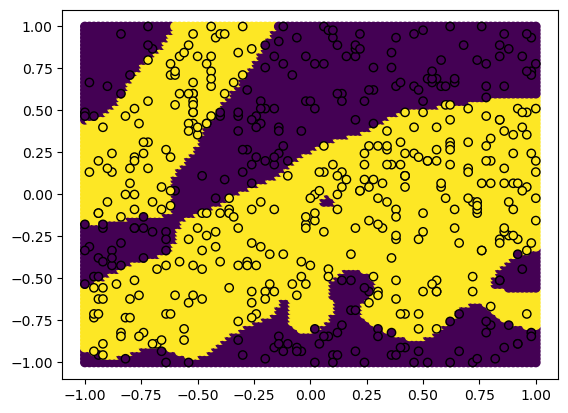

In [58]:
x_span = np.arange(101)
y_span = np.arange(91)
xx, yy = np.meshgrid(x_span, y_span)
indices = np.append(xx.ravel().reshape(xx.ravel().shape[0], 1),
                   yy.ravel().reshape(yy.ravel().shape[0], 1),
                   axis=1)


plt.scatter(values[:,0], values[:,1], c=imagenp[indices[:,0],indices[:,1]])
plt.scatter(pts_obs[:,0],pts_obs[:,1], c=z_obs, edgecolors='k')
plt.show()

In [81]:
rbf.centres[:,0]

tensor([-0.3533,  0.7332, -0.2116,  0.7332, -0.7112,  0.1664, -0.4572, -0.8960,
         0.2518, -0.7200, -0.8953,  0.1515,  0.7331,  0.0893,  0.1515,  0.0888,
         0.4876,  0.9013, -0.3748, -0.2454, -0.8953, -0.8952,  0.7330, -0.6409,
         0.7332, -0.3803,  0.7332,  0.0896, -0.5149,  0.6669, -0.4635, -0.3021,
         0.9720, -0.9738, -0.7054,  0.6201,  0.1664,  0.1895,  0.7978,  0.1515],
       grad_fn=<SelectBackward0>)

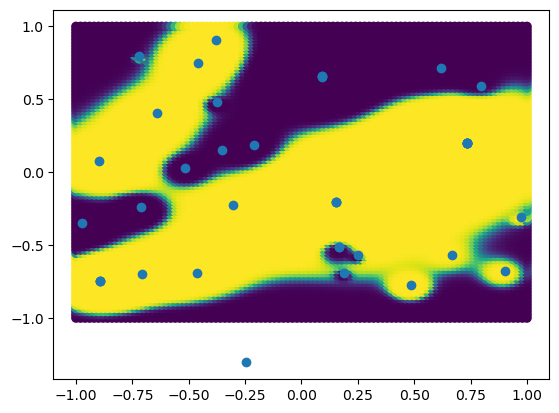

In [83]:
# Plotting the ideal and learned decision boundaries

with torch.no_grad():
    preds = (torch.sigmoid(rbfnet(torch.from_numpy(values).float()))).data.numpy()

plt.scatter(values[:,0], values[:,1], c=preds)
plt.scatter(rbf.centres[:,0].detach(), rbf.centres[:,1].detach())
plt.show()

# ideal_0 = values[np.where(values[:,1] <= 0.5*np.cos(np.pi*values[:,0]) + 0.5*np.cos(4*np.pi*(values[:,0]+1)))[0]]
# ideal_1 = values[np.where(values[:,1] > 0.5*np.cos(np.pi*values[:,0]) + 0.5*np.cos(4*np.pi*(values[:,0]+1)))[0]]
# area_0 = values[np.where(preds[:, 0] <= 0.5)[0]]
# area_1 = values[np.where(preds[:, 0] > 0.5)[0]]

# fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
# ax[0].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
# ax[0].scatter(x[samples//2:,0], x[samples//2:,1], c='orange', marker='x')
# ax[0].scatter(ideal_0[:, 0], ideal_0[:, 1], alpha=0.1, c='dodgerblue')
# ax[0].scatter(ideal_1[:, 0], ideal_1[:, 1], alpha=0.1, c='orange')
# ax[0].set_xlim([-1,1])
# ax[0].set_ylim([-1,1])
# ax[0].set_title('Ideal Decision Boundary')
# ax[1].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
# ax[1].scatter(x[samples//2:,0], x[samples//2:,1], c='orange', marker='x')
# ax[1].scatter(area_0[:, 0], area_0[:, 1], alpha=0.1, c='dodgerblue')
# ax[1].scatter(area_1[:, 0], area_1[:, 1], alpha=0.1, c='orange')
# ax[1].set_xlim([-1,1])
# ax[1].set_ylim([-1,1])
# ax[1].set_title('RBF Decision Boundary')
# plt.show()

## original

In [24]:
# Generating a dataset for a given decision boundary

x1 = np.linspace(-1, 1, 101)
x2 = 0.5*np.cos(np.pi*x1) + 0.5*np.cos(4*np.pi*(x1+1)) # <- decision boundary

samples = 200
x = np.random.uniform(-1, 1, (samples, 2))
for i in range(samples):
    if i < samples//2:
        x[i,1] = np.random.uniform(-1, 0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)))
    else:
        x[i,1] = np.random.uniform(0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)), 1)

steps = 100
x_span = np.linspace(-1, 1, steps)
y_span = np.linspace(-1, 1, steps)
xx, yy = np.meshgrid(x_span, y_span)
values = np.append(xx.ravel().reshape(xx.ravel().shape[0], 1),
                   yy.ravel().reshape(yy.ravel().shape[0], 1),
                   axis=1)

tx = torch.from_numpy(x).float()
ty = torch.cat((torch.zeros(samples//2,1), torch.ones(samples//2,1)), dim=0)



# Instanciating and training an RBF network with the Gaussian basis function
# This network receives a 2-dimensional input, transforms it into a 40-dimensional
# hidden representation with an RBF layer and then transforms that into a
# 1-dimensional output/prediction with a linear layer

# To add more layers, change the layer_widths and layer_centres lists

layer_widths = [2, 1]
layer_centres = [40]
basis_func = rbf.gaussian

rbfnet = Network(layer_widths, layer_centres, basis_func)
rbfnet.fit(tx, ty, 5000, samples, 0.01, nn.BCEWithLogitsLoss())
rbfnet.eval()


Epoch: 5000, Progress: 200/200, Loss: 0.001746      

Network(
  (rbf_layers): ModuleList(
    (0): RBF()
  )
  (linear_layers): ModuleList(
    (0): Linear(in_features=40, out_features=1, bias=True)
  )
)

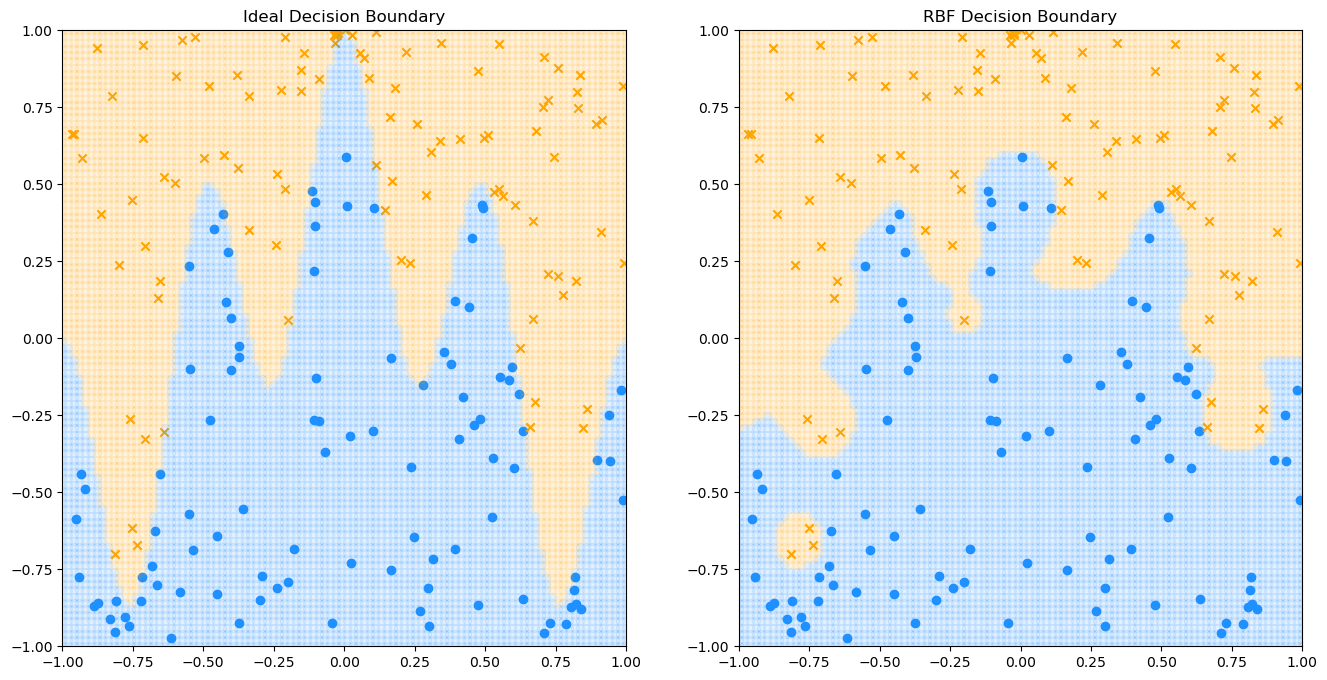

In [25]:
# Plotting the ideal and learned decision boundaries

with torch.no_grad():
    preds = (torch.sigmoid(rbfnet(torch.from_numpy(values).float()))).data.numpy()
ideal_0 = values[np.where(values[:,1] <= 0.5*np.cos(np.pi*values[:,0]) + 0.5*np.cos(4*np.pi*(values[:,0]+1)))[0]]
ideal_1 = values[np.where(values[:,1] > 0.5*np.cos(np.pi*values[:,0]) + 0.5*np.cos(4*np.pi*(values[:,0]+1)))[0]]
area_0 = values[np.where(preds[:, 0] <= 0.5)[0]]
area_1 = values[np.where(preds[:, 0] > 0.5)[0]]

fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
ax[0].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
ax[0].scatter(x[samples//2:,0], x[samples//2:,1], c='orange', marker='x')
ax[0].scatter(ideal_0[:, 0], ideal_0[:, 1], alpha=0.1, c='dodgerblue')
ax[0].scatter(ideal_1[:, 0], ideal_1[:, 1], alpha=0.1, c='orange')
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-1,1])
ax[0].set_title('Ideal Decision Boundary')
ax[1].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
ax[1].scatter(x[samples//2:,0], x[samples//2:,1], c='orange', marker='x')
ax[1].scatter(area_0[:, 0], area_0[:, 1], alpha=0.1, c='dodgerblue')
ax[1].scatter(area_1[:, 0], area_1[:, 1], alpha=0.1, c='orange')
ax[1].set_xlim([-1,1])
ax[1].set_ylim([-1,1])
ax[1].set_title('RBF Decision Boundary')
plt.show()

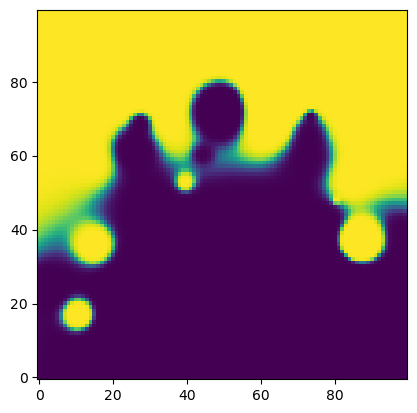

In [32]:
plt.imshow(preds.reshape(100,100), origin='lower')